In [15]:
from utils import HF_Sklearn_Ensemble, FeatureExtractor, ClassifierWithBinarization, SentimentFeatures
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
RANDOM_SEED = 42
TRAIN_DATA_PATH = "data/PCL_train_dataset.tsv"
VAL_DATA_PATH = "data/PCL_val_dataset.tsv"
TEST_DATA_PATH = "data/PCL_test_dataset.tsv"

# Data and Model Imports

In [8]:
def x_y_split(df: pd.DataFrame):
    y_categorical = df["PCL_category"]
    y_binary = df["labels"]
    X = df.drop(columns=["PCL_category", "labels"])
    return X, y_binary, y_categorical

def data_preprocess(data_path: str, is_train: bool = False, is_test: bool = False):
    columns = ["article_id", "keyword", "country", "text"]
    if not is_test:
        columns += ["PCL_category"]

    df = pd.read_csv(
        data_path,
        sep="\t",
        skiprows=9,
        engine="python",
        index_col=0,
        header=None,
        names=columns,
    )

    if is_train:
        df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        # df_train = clean_df(df_train)

    if not is_test:
        df["labels"] = (df["PCL_category"] >= 2).astype("int64")

    df["text"] = df["text"].astype(str).fillna("")

    return df


In [9]:
X_train, y_train_b, y_train_c, = x_y_split(data_preprocess(TRAIN_DATA_PATH, is_train = True))
X_val, y_val_b, y_val_c, = x_y_split(data_preprocess(VAL_DATA_PATH))
X_test = data_preprocess(TEST_DATA_PATH, is_test=True)

In [ ]:
ENSEMBLE_PATH = Path("models/ensemble_model/ensemble_model.joblib")  # <-- change if needed
ensemble_obj = joblib.load(ENSEMBLE_PATH)

# Evaluation

In [11]:
def evaluate(X: pd.DataFrame, y_true):
    y_pred = ensemble_obj.predict(X)
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {pr:.4f}")
    print(f"Recall   : {rc:.4f}")
    print(f"F1       : {f1:.4f}\n")
    print("Confusion matrix:\n", cm, "\n")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    return y_pred


print("\n TRAIN Evaluation: \n")
y_pred_train = evaluate(X_train, y_train_b)

print("\n VAL Evaluation: \n")
y_pred_val = evaluate(X_val, y_val_b)


 TRAIN Evaluation: 



  0%|          | 0/8367 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tr

Accuracy : 0.9778
Precision: 0.8958
Recall   : 0.8665
F1       : 0.8809

Confusion matrix:
 [[7493   80]
 [ 106  688]] 

              precision    recall  f1-score   support

           0     0.9861    0.9894    0.9877      7573
           1     0.8958    0.8665    0.8809       794

    accuracy                         0.9778      8367
   macro avg     0.9409    0.9280    0.9343      8367
weighted avg     0.9775    0.9778    0.9776      8367


 VAL Evaluation: 



/opt/homebrew/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
  0%|          | 0/2086 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(

Accuracy : 0.9252
Precision: 0.5897
Recall   : 0.6021
F1       : 0.5959

Confusion matrix:
 [[1815   80]
 [  76  115]] 

              precision    recall  f1-score   support

           0     0.9598    0.9578    0.9588      1895
           1     0.5897    0.6021    0.5959       191

    accuracy                         0.9252      2086
   macro avg     0.7748    0.7799    0.7773      2086
weighted avg     0.9259    0.9252    0.9256      2086



/opt/homebrew/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


We can see that the f1 score is higher in train (0.88) than in testing (0.60). This is an indicator of overfitting. This could be solved by increased regularization.

## Feature Based Evaluation

In [16]:
eval_df = X_val.copy()
eval_df["y_true"] = y_val_b
eval_df["y_pred"] = y_pred_val
eval_df["correct"] = (eval_df["y_true"] == eval_df["y_pred"])

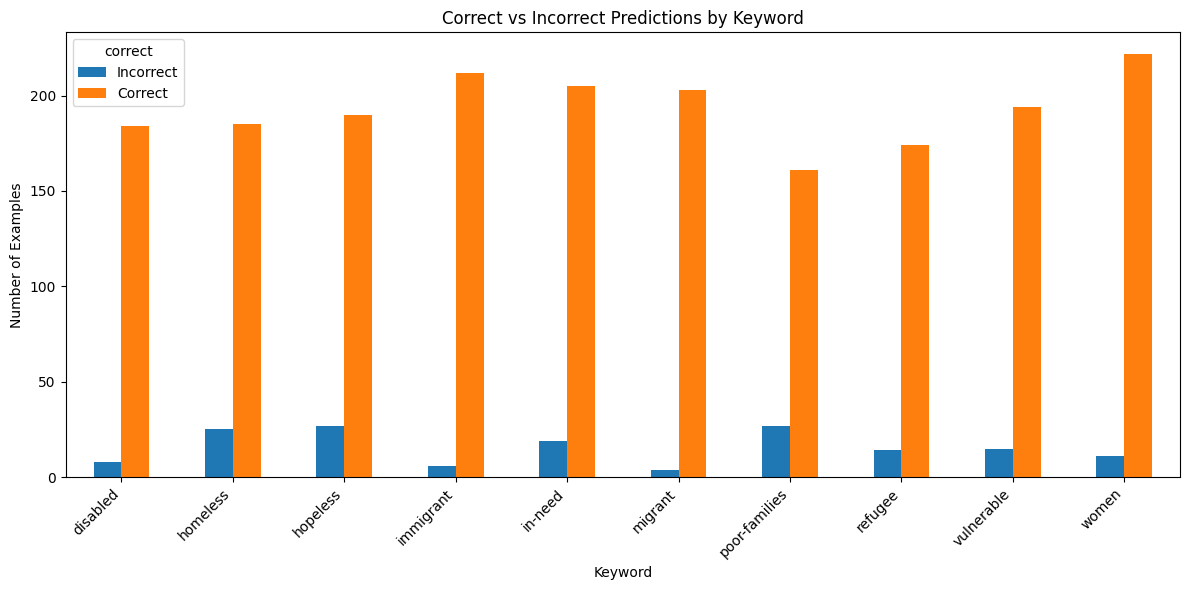

In [17]:
# Aggregate counts
kw_counts = (
    eval_df
    .groupby(["keyword", "correct"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={True: "Correct", False: "Incorrect"})
)

kw_counts.plot(
    kind="bar",
    figsize=(12, 6),
    stacked=False
)

plt.title("Correct vs Incorrect Predictions by Keyword")
plt.xlabel("Keyword")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [19]:
keyword_error_table = (
    eval_df
    .groupby("keyword")
    .agg(
        total_examples=("correct", "size"),
        incorrect_examples=("correct", lambda x: (~x).sum())
    )
)

keyword_error_table["incorrect_ratio"] = (
    keyword_error_table["incorrect_examples"] / keyword_error_table["total_examples"]
)

# Sort by highest error ratio
keyword_error_table = keyword_error_table.sort_values(
    by="incorrect_ratio", ascending=False
)

keyword_error_table

,total_examples,incorrect_examples,incorrect_ratio
keyword,,,
poor-families,188,27,0.143617
hopeless,217,27,0.124424
homeless,210,25,0.119048
in-need,224,19,0.084821
refugee,188,14,0.074468
vulnerable,209,15,0.071770
women,233,11,0.047210
disabled,192,8,0.041667
immigrant,218,6,0.027523


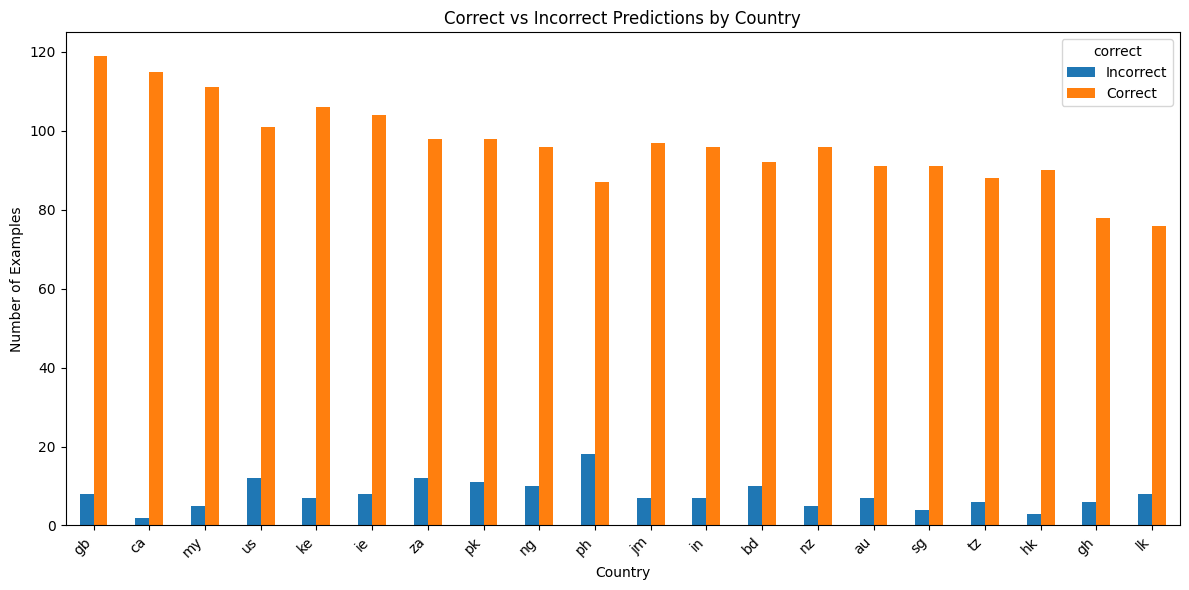

In [18]:
# Aggregate counts
country_counts = (
    eval_df
    .groupby(["country", "correct"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={True: "Correct", False: "Incorrect"})
)

# Optional: sort by total frequency
country_counts["Total"] = country_counts.sum(axis=1)
country_counts = country_counts.sort_values("Total", ascending=False).drop(columns="Total")

# Plot
country_counts.plot(
    kind="bar",
    figsize=(12, 6),
    stacked=False
)

plt.title("Correct vs Incorrect Predictions by Country")
plt.xlabel("Country")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
# Error ratio per country
country_error_table = (
    eval_df
    .groupby("country")
    .agg(
        total_examples=("correct", "size"),
        incorrect_examples=("correct", lambda x: (~x).sum())
    )
)

country_error_table["incorrect_ratio"] = (
    country_error_table["incorrect_examples"] / country_error_table["total_examples"]
)

# Sort by highest error ratio
country_error_table = country_error_table.sort_values(
    by="incorrect_ratio", ascending=False
)

country_error_table

,total_examples,incorrect_examples,incorrect_ratio
country,,,
ph,105,18,0.171429
za,110,12,0.109091
us,113,12,0.106195
pk,109,11,0.100917
bd,102,10,0.098039
lk,84,8,0.095238
ng,106,10,0.094340
ie,112,8,0.071429
gh,84,6,0.071429


We can see that there are big ranges of accuracy for both country and keyword. However, the accuracy changes does not seem correlated with the number of points for the category. So, we don't expect class weighting to solve the issue. Nevertheless, this information can be used to adjust confidence levels on data points.

In [21]:
eval_df["length"] = eval_df["text"].str.split().apply(len)

eval_df.groupby(pd.qcut(eval_df["length"], 4))["correct"].mean()

/var/folders/zx/7nt78dzs2lbccbwfzr2blrrr0000gn/T/ipykernel_60638/196843407.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eval_df.groupby(pd.qcut(eval_df["length"], 4))["correct"].mean()


length
(0.999, 30.0]    0.946333
(30.0, 41.0]     0.930612
(41.0, 58.0]     0.942085
(58.0, 272.0]    0.880539
Name: correct, dtype: float64

We can see that when the sentence length increases correctness ratio decreases. This could be due to the mix of many embeddings causing the relevant part of the paragraph to lose its importance. This could be improved through the use of keywords to in=dentify relevant sections of the text and weighting those sections in the embeddings.

In [25]:
eval_df["error_type"] = "correct"
eval_df.loc[(eval_df.y_true == 0) & (eval_df.y_pred == 1), "error_type"] = "false_positive"
eval_df.loc[(eval_df.y_true == 1) & (eval_df.y_pred == 0), "error_type"] = "false_negative"

In [27]:
def print_examples(df, title, n=3):
    print("=" * 80)
    print(title)
    print("=" * 80)

    for i, row in df.head(n).iterrows():
        print(f"\nID: {row.get('par_id', i)}")
        print(f"True label : {row.y_true}")
        print(f"Pred label : {row.y_pred}")
        print("Text:")
        print(row.text)
        print("-" * 80)

In [36]:
true_positives = eval_df[(eval_df.y_true == 1) & (eval_df.y_pred == 1)]

print_examples(
    true_positives,
    title="TRUE POSITIVES — Correctly detected PCL",
    n=3
)

TRUE POSITIVES — Correctly detected PCL

ID: 369
True label : 1
Pred label : 1
Text:
" People do n't understand the hurt , people do n't understand the pain . I 've read about women with their children sleeping in cars , sleeping in hotel rooms and it 's criminal . If they 're lucky and they come across COPE Galway and the ladies in Osterley , then there 's hope . "
--------------------------------------------------------------------------------

ID: 490
True label : 1
Pred label : 1
Text:
18 December should serve as a time when we look with compassion at the fate of migrants , refugees and the internally displaced . It is especially a time when we must plan and increase resources for creative action .
--------------------------------------------------------------------------------

ID: 498
True label : 1
Pred label : 1
Text:
Almost apocalyptic in its devastation , the wrath of one of the most powerful storms ever to hit the Atlantic is evidenced in the smashed ruins of Barbuda 's cand

In [38]:
true_negatives = eval_df[(eval_df.y_true == 0) & (eval_df.y_pred == 0)]

print_examples(
    true_negatives,
    title="TRUE NEGATIVES — Correctly rejected non-PCL",
    n=3
)

TRUE NEGATIVES — Correctly rejected non-PCL

ID: 8387
True label : 0
Pred label : 0
Text:
Asylum seekers from Somalia were asked to report to Dadaab while those from other countries were asked to report to Kakuma refugee camp .
--------------------------------------------------------------------------------

ID: 8388
True label : 0
Pred label : 0
Text:
Last week , the rights office reported dozens of execution-style killings in villages near Mosul , including the shooting of a physically disabled girl who failed to keep up on a forced march .
--------------------------------------------------------------------------------

ID: 8389
True label : 0
Pred label : 0
Text:
Recommended changes to residential consumer tariff schemes will be designed to give more relief to poor families , especially those living in compound houses . <h> National Builders Corps
--------------------------------------------------------------------------------


In [ ]:
print_examples(
    eval_df[eval_df.error_type == "false_positive"],
    title="False positives",
    n=3
)

False positives (high confidence)

ID: 8391
True label : 0
Pred label : 1
Text:
Marcos said the government should help poor families that try every possible means to survive . With Joel Zurbano <h> More from this Category :
--------------------------------------------------------------------------------

ID: 8472
True label : 0
Pred label : 1
Text:
" The proceeds from Lady Lucan 's estate will help Shelter to continue fighting bad housing and homelessness . "
--------------------------------------------------------------------------------

ID: 8473
True label : 0
Pred label : 1
Text:
The Jali family in Brown 's Farm was elated as the City of Cape Town donated wheelchairs to their disabled members .
--------------------------------------------------------------------------------


In [ ]:
print_examples(
    eval_df[eval_df.error_type == "false_negative"],
    title="False negatives",
    n=3
)

False negatives (high confidence)

ID: 432
True label : 1
Pred label : 0
Text:
He depicts demonstrations by refugees at the border post , their catastrophic living conditions and the desperate attempt of several hundred to cross a river a few kilometres from the camp to get into Macedonia on 14 March 2016 .
--------------------------------------------------------------------------------

ID: 582
True label : 1
Pred label : 0
Text:
It 's calculated that over 204,000 days of purpose-built residential accommodation to otherwise potentially homeless elderly men and women have been delivered by this personally driven altruistic act alone .
--------------------------------------------------------------------------------

ID: 644
True label : 1
Pred label : 0
Text:
" I and my daughter Monica are excited about providing a space for disabled people to be able to get together and earn fair prices for their work , " Mr. Rogers said .
---------------------------------------------------------------

From the examples, we can see that when there are many recognized entities model tends to classify it as not PCL and result in false negatives. This might be a pattern due to the recognized entities making the sentence sound more trustworthy. On the other hand, the false positives are usually shorter sentences. This could be due to the numerical ratios in the ML-pipeline model to be higher. As an improvement false examples can be examined more in depth and dynamic scaling of impacts of the two models could be used depending on the input properties like text length.